# EPM Startup Shear

> **Handbook:** See [Lattice EPM — Startup Protocol](../../docs/source/models/epm/lattice_epm.rst#epm-startup) for mathematical details with boxed governing equations.

**EPM Startup Physics:** In startup shear at constant shear rate $\dot{\gamma}$, EPM captures the characteristic **stress overshoot** that occurs when an amorphous material transitions from elastic loading to plastic flow. This overshoot is a signature of avalanche dynamics — the onset of cascading yielding events mediated by the Eshelby propagator.

### Stress Overshoot Mechanism

The stress evolution $\sigma(t)$ during startup proceeds through three stages:

1. **Initial elastic loading**: $\sigma(t) \approx \mu \dot{\gamma} t$ (linear regime, no yielding)
2. **Avalanche onset**: First sites exceed $\sigma_{c,i}$ → stress redistribution via Eshelby $\mathcal{G}_{ij}$
3. **Cascading plasticity**: Neighboring sites yield → stress peak at $t_{\text{peak}}$
4. **Steady state**: Balance between loading and plastic dissipation → plateau $\sigma_\infty$

### Key Metrics

| Metric | Symbol | Physical Meaning |
|--------|--------|------------------|
| Peak stress | $\sigma_{\text{max}}$ | Maximum stress before avalanche cascade |
| Peak time | $t_{\text{peak}}$ | Time to avalanche onset |
| Peak strain | $\gamma_{\text{peak}} = \dot{\gamma} \cdot t_{\text{peak}}$ | Effective yield strain (~material constant) |
| Steady stress | $\sigma_\infty$ | Flow stress at long times |
| Overshoot ratio | $\sigma_{\text{max}}/\sigma_\infty$ | Avalanche strength |

### Rate Dependence

At higher shear rates $\dot{\gamma}$:
- **$t_{\text{peak}}$ decreases**: Less time for elastic loading
- **$\gamma_{\text{peak}} \approx$ constant**: Yield strain is material-dependent (disorder-controlled)
- **$\sigma_{\text{max}}/\sigma_\infty$ may vary**: Depends on disorder strength $\sigma_{c,\text{std}}/\sigma_{c,\text{mean}}$

### Materials

Classic startup behavior appears in:
- Metallic glasses (sharp overshoot, serrated flow)
- Colloidal gels (overshoot → cage breaking)
- Concentrated emulsions (overshoot → droplet rearrangement)
- Pastes (overshoot → shear banding onset)

## Learning Objectives

- Understand stress overshoot in EPM as avalanche onset
- Generate synthetic startup data from calibrated flow curve parameters
- Fit startup data and recover original parameters (parameter recovery test)
- Predict $N_1(t)$ evolution using TensorialEPM

## Prerequisites

- Complete `01_epm_flow_curve.ipynb` first (provides calibrated parameters)
- Understanding of startup shear protocol $\sigma(t)$ at constant $\dot{\gamma}$

## Estimated Runtime

- Fast demo (1 chain): ~3-4 min
- Full run (4 chains): ~8-12 min

## 1. Setup & Imports

In [1]:
# Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import json
import os
import sys
import time

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.epm.lattice import LatticeEPM
from rheojax.models.epm.tensor import TensorialEPM

jax, jnp = safe_import_jax()
verify_float64()

FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
print(f"FAST_MODE: {FAST_MODE}")

def compute_fit_quality(y_true, y_pred):
    """Compute R2 and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {"R2": r2, "RMSE": rmse}

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]
FAST_MODE: True


## 2. Theory: Startup in EPM

In startup shear, we apply a constant shear rate γ̇ starting from rest and monitor σ(t).

### Stress Overshoot Physics

The characteristic **stress overshoot** in EPM arises from:

1. **Initial elastic loading**: σ(t) ≈ μγ̇t (linear regime)
2. **Avalanche onset**: First yielding events trigger stress redistribution
3. **Cascading plasticity**: Eshelby propagator causes neighboring sites to yield
4. **Steady state**: Balance between loading and plastic dissipation

### Key Metrics

| Metric | Symbol | Physical Meaning |
|--------|--------|------------------|
| Peak stress | σ_max | Maximum stress before yielding cascade |
| Peak time | t_peak | Time to avalanche onset |
| Peak strain | γ_peak = γ̇·t_peak | Strain to yielding (~yield strain) |
| Steady stress | σ_∞ | Flow stress at long times |
| Overshoot ratio | σ_max/σ_∞ | Measures avalanche strength |

### Rate Dependence

At higher shear rates:
- **t_peak decreases**: Less time for elastic loading
- **γ_peak ≈ constant**: Yield strain is material-dependent
- **σ_max/σ_∞ may vary**: Depends on disorder and rate

## 3. Load Calibrated Parameters

We load parameters from Notebook 01 (flow curve fitting). If not available, we use default values.

In [3]:
# Try to load from Notebook 01 output
params_file = os.path.join("..", "outputs", "epm", "flow_curve", "nlsq_params.json")

if os.path.exists(params_file):
    with open(params_file) as f:
        true_params = json.load(f)
    print("Loaded calibrated parameters from Notebook 01:")
else:
    # Default parameters for demonstration
    true_params = {
        "mu": 2.5,
        "tau_pl": 1.0,
        "sigma_c_mean": 25.0,
        "sigma_c_std": 2.5,
    }
    print("Using default parameters (run Notebook 01 to use calibrated values):")

for k, v in true_params.items():
    if k in ["mu", "tau_pl", "sigma_c_mean", "sigma_c_std"]:
        print(f"  {k}: {v:.4g}")

Using default parameters (run Notebook 01 to use calibrated values):
  mu: 2.5
  tau_pl: 1
  sigma_c_mean: 25
  sigma_c_std: 2.5


## 4. Generate Synthetic Startup Data

We generate synthetic startup data using the calibrated parameters, then add 3% Gaussian noise.

In [4]:
# Simulation parameters
GAMMA_DOT = 1.0      # Applied shear rate [1/s]
T_END = 10.0         # End time [s]
N_POINTS = 80        # Number of data points
NOISE_LEVEL = 0.03   # 3% noise
SEED = 42

print(f"Generating startup data at γ̇ = {GAMMA_DOT} 1/s")
print(f"  Time range: 0 – {T_END} s")
print(f"  Data points: {N_POINTS}")
print(f"  Noise level: {NOISE_LEVEL*100:.0f}%")

Generating startup data at γ̇ = 1.0 1/s
  Time range: 0 – 10.0 s
  Data points: 80
  Noise level: 3%


In [5]:
# Create model with true parameters
model_true = LatticeEPM(
    L=16 if FAST_MODE else 32,
    dt=0.01,
    mu=true_params.get("mu", 2.5),
    tau_pl=true_params.get("tau_pl", 1.0),
    sigma_c_mean=true_params.get("sigma_c_mean", 25.0),
    sigma_c_std=true_params.get("sigma_c_std", 2.5),
)

# Generate time array
time_data = np.linspace(0.1, T_END, N_POINTS)  # Start at 0.1 to avoid t=0

# Create RheoData for startup
rheo_data = RheoData(
    x=time_data,
    y=np.zeros_like(time_data),
    initial_test_mode="startup",
    metadata={"gamma_dot": GAMMA_DOT},
)

# Simulate clean signal
print("Running EPM startup simulation...")
t0 = time.time()
result_clean = model_true.predict(rheo_data, smooth=True, seed=SEED)
t_sim = time.time() - t0
print(f"Simulation time: {t_sim:.2f} s")

stress_clean = np.array(result_clean.y)

# Add noise (use absolute mean to handle negative-stress scenarios)
rng = np.random.default_rng(SEED)
noise_scale = NOISE_LEVEL * max(np.abs(np.mean(stress_clean)), 1e-10)
noise = rng.normal(0, noise_scale, size=stress_clean.shape)
stress_noisy = stress_clean + noise

print(f"Stress range: {stress_noisy.min():.2f} - {stress_noisy.max():.2f} Pa")

Running EPM startup simulation...


Simulation time: 0.51 s
Stress range: -0.07 - 22.28 Pa


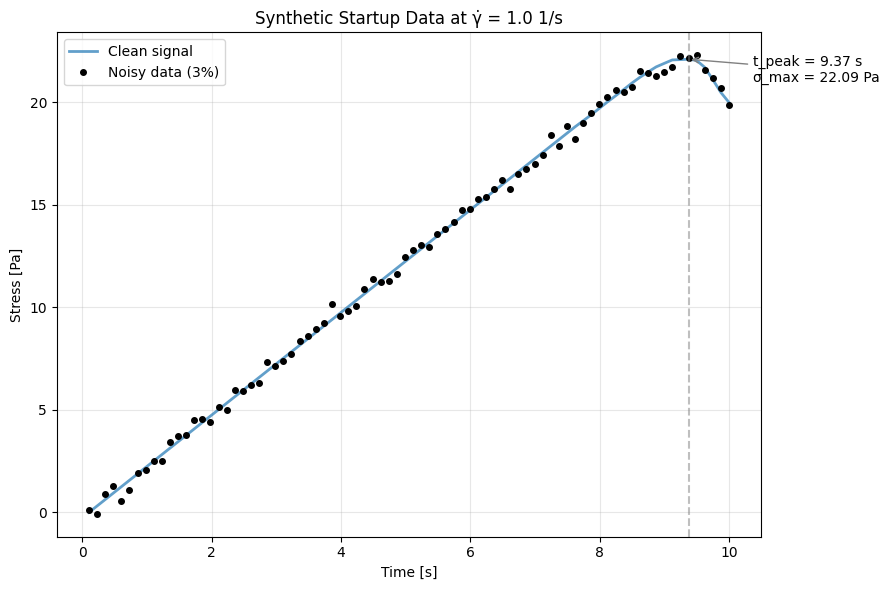

In [6]:
fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(time_data, stress_clean, "-", lw=2, color="C0", label="Clean signal", alpha=0.7)
ax.plot(time_data, stress_noisy, "ko", markersize=4, label="Noisy data (3%)")

# Mark overshoot
idx_peak = np.argmax(stress_clean)
ax.axvline(time_data[idx_peak], color="gray", linestyle="--", alpha=0.5)
ax.annotate(
    f"t_peak = {time_data[idx_peak]:.2f} s\nσ_max = {stress_clean[idx_peak]:.2f} Pa",
    xy=(time_data[idx_peak], stress_clean[idx_peak]),
    xytext=(time_data[idx_peak] + 1, stress_clean[idx_peak] * 0.95),
    fontsize=10,
    arrowprops=dict(arrowstyle="->", color="gray"),
)

ax.set_xlabel("Time [s]")
ax.set_ylabel("Stress [Pa]")
ax.set_title(f"Synthetic Startup Data at γ̇ = {GAMMA_DOT} 1/s")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Overshoot Metrics

In [7]:
# Compute overshoot metrics
idx_peak = np.argmax(stress_clean)
sigma_max = stress_clean[idx_peak]
t_peak = time_data[idx_peak]
gamma_peak = GAMMA_DOT * t_peak

# Steady state (average of last 20% of data)
n_steady = max(5, len(stress_clean) // 5)
sigma_inf = np.mean(stress_clean[-n_steady:])

overshoot_ratio = sigma_max / sigma_inf

print("Overshoot Metrics")
print("=" * 40)
print(f"Peak stress σ_max:     {sigma_max:.3f} Pa")
print(f"Peak time t_peak:      {t_peak:.3f} s")
print(f"Peak strain γ_peak:    {gamma_peak:.3f}")
print(f"Steady stress σ_∞:     {sigma_inf:.3f} Pa")
print(f"Overshoot ratio:       {overshoot_ratio:.3f}")
print(f"\nInterpretation:")
print(f"  γ_peak ≈ {gamma_peak:.2f} is the effective yield strain")
print(f"  Overshoot of {(overshoot_ratio-1)*100:.1f}% indicates avalanche dynamics")

Overshoot Metrics
Peak stress σ_max:     22.089 Pa
Peak time t_peak:      9.373 s
Peak strain γ_peak:    9.373
Steady stress σ_∞:     21.226 Pa
Overshoot ratio:       1.041

Interpretation:
  γ_peak ≈ 9.37 is the effective yield strain
  Overshoot of 4.1% indicates avalanche dynamics


## 6. NLSQ Fitting (Parameter Recovery)

In [8]:
# Initialize model for fitting (start from different initial values)
model_fit = LatticeEPM(
    L=16 if FAST_MODE else 32,
    dt=0.01,
    mu=1.0,           # Different from true
    tau_pl=0.5,       # Different from true
    sigma_c_mean=10.0,
    sigma_c_std=1.0,
)

# Set bounds
model_fit.parameters["mu"].bounds = (0.1, 20.0)
model_fit.parameters["tau_pl"].bounds = (0.01, 50.0)
model_fit.parameters["sigma_c_mean"].bounds = (0.5, 100.0)
model_fit.parameters["sigma_c_std"].bounds = (0.01, 20.0)

# Fit
print("Fitting to synthetic startup data...")
t0 = time.time()
model_fit.fit(time_data, stress_noisy, test_mode="startup", gamma_dot=GAMMA_DOT, method='scipy')
t_nlsq = time.time() - t0

# Compute fit quality
y_pred = model_fit.predict(time_data, test_mode="startup", gamma_dot=GAMMA_DOT, smooth=True, seed=SEED).y
metrics = compute_fit_quality(stress_noisy, y_pred)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"R2: {metrics['R2']:.6f}")
print(f"RMSE: {metrics['RMSE']:.4f} Pa")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Fitting to synthetic startup data...


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.332175s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=13.6378 | elapsed=1.332s | final_gradient_norm=0.1355


NLSQ fit time: 2.38 s
R2: 0.669069
RMSE: 3.9660 Pa


In [9]:
# Compare fitted vs true parameters
param_names = ["mu", "tau_pl", "sigma_c_mean", "sigma_c_std"]

print("\nParameter Recovery")
print("=" * 55)
print(f"{'Parameter':>15s}  {'True':>10s}  {'Fitted':>10s}  {'Error %':>10s}")
print("-" * 55)

for name in param_names:
    true_val = true_params.get(name, 1.0)
    fit_val = model_fit.parameters.get_value(name)
    error_pct = abs(fit_val - true_val) / true_val * 100
    print(f"{name:>15s}  {true_val:10.4g}  {fit_val:10.4g}  {error_pct:10.1f}%")


Parameter Recovery
      Parameter        True      Fitted     Error %
-------------------------------------------------------
             mu         2.5       1.754        29.8%
         tau_pl           1        21.1      2009.6%
   sigma_c_mean          25       28.64        14.6%
    sigma_c_std         2.5      0.4026        83.9%


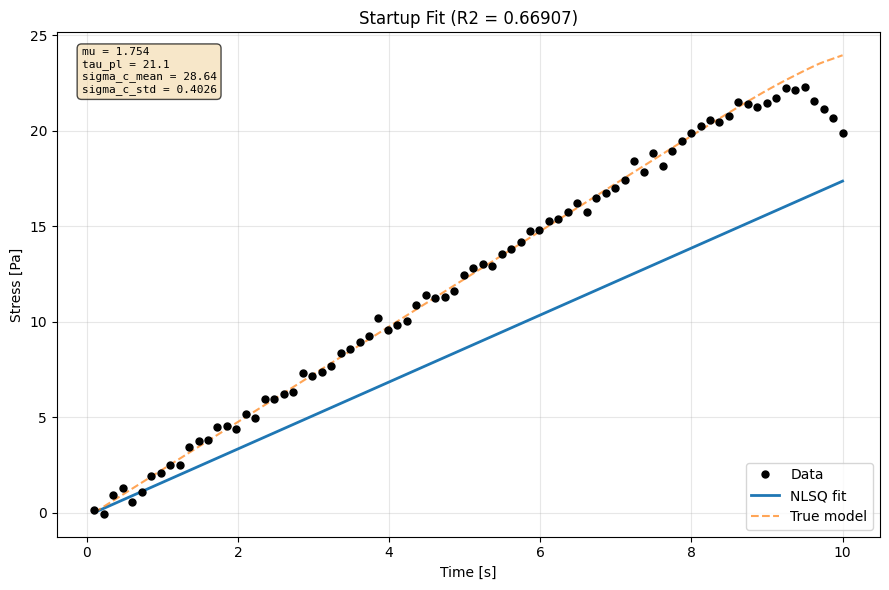

In [10]:
# Plot NLSQ fit with uncertainty band
param_names = ["mu", "tau_pl", "sigma_c_mean", "sigma_c_std"]

time_fine = np.linspace(0.1, T_END, 200)
rheo_fine = RheoData(
    x=time_fine, y=np.zeros_like(time_fine),
    initial_test_mode="startup",
    metadata={"gamma_dot": GAMMA_DOT},
)

fig, ax = plt.subplots(figsize=(9, 6))
# Pass x_pred=time_data to avoid fine-grid shape mismatch in EPM
plot_nlsq_fit(
    time_data, stress_noisy, model_fit, test_mode="startup",
    param_names=param_names, x_pred=time_data, log_scale=False,
    xlabel="Time [s]", ylabel="Stress [Pa]",
    title=f"Startup Fit (R2 = {metrics['R2']:.5f})",
    ax=ax, gamma_dot=GAMMA_DOT,
)

# Overlay true model
stress_true = model_true.predict(rheo_fine, smooth=True, seed=SEED).y
ax.plot(time_fine, stress_true, "--", lw=1.5, color="C1", alpha=0.7, label="True model")
ax.legend()

plt.tight_layout()
display(fig)
plt.close(fig)

## 7. Bayesian Inference

In [11]:
# Warm-start from NLSQ
initial_values = {
    name: model_fit.parameters.get_value(name)
    for name in model_fit.parameters.keys()
}

# --- Fast demo config ---
NUM_WARMUP = 50 if FAST_MODE else 200
NUM_SAMPLES = 100 if FAST_MODE else 500
NUM_CHAINS = 1

print(f"Running Bayesian inference: {NUM_CHAINS} chain(s)")

t0 = time.time()
result = model_fit.fit_bayesian(
    time_data,
    stress_noisy,
    test_mode="startup",
    gamma_dot=GAMMA_DOT,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"Bayesian inference time: {t_bayes:.1f} s")

Running Bayesian inference: 1 chain(s)


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:01<02:47,  1.12s/it, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:   4%|▍         | 6/150 [00:01<00:25,  5.68it/s, 175 steps of size 5.87e-03. acc. prob=0.50]

warmup:   5%|▌         | 8/150 [00:01<00:30,  4.69it/s, 255 steps of size 7.13e-03. acc. prob=0.61]

warmup:   6%|▌         | 9/150 [00:02<00:28,  4.92it/s, 143 steps of size 7.79e-03. acc. prob=0.65]

warmup:   7%|▋         | 10/150 [00:02<00:30,  4.53it/s, 255 steps of size 1.04e-02. acc. prob=0.68]

warmup:   7%|▋         | 11/150 [00:02<00:32,  4.27it/s, 255 steps of size 1.16e-02. acc. prob=0.71]

warmup:   8%|▊         | 12/150 [00:02<00:33,  4.09it/s, 255 steps of size 7.73e-03. acc. prob=0.71]

warmup:   9%|▊         | 13/150 [00:03<00:28,  4.81it/s, 95 steps of size 4.61e-03. acc. prob=0.71] 

warmup:   9%|▉         | 14/150 [00:03<00:31,  4.37it/s, 255 steps of size 6.40e-03. acc. prob=0.73]

warmup:  10%|█         | 15/150 [00:03<00:34,  3.86it/s, 191 steps of size 7.03e-03. acc. prob=0.74]

warmup:  11%|█         | 16/150 [00:03<00:37,  3.56it/s, 255 steps of size 9.77e-03. acc. prob=0.76]

warmup:  11%|█▏        | 17/150 [00:04<00:31,  4.23it/s, 101 steps of size 1.20e-02. acc. prob=0.77]

warmup:  12%|█▏        | 18/150 [00:04<00:27,  4.83it/s, 115 steps of size 1.04e-02. acc. prob=0.77]

warmup:  13%|█▎        | 19/150 [00:04<00:28,  4.58it/s, 199 steps of size 1.02e-02. acc. prob=0.78]

warmup:  13%|█▎        | 20/150 [00:04<00:31,  4.18it/s, 255 steps of size 1.32e-02. acc. prob=0.79]

warmup:  16%|█▌        | 24/150 [00:04<00:13,  9.54it/s, 7 steps of size 8.93e-03. acc. prob=0.80]  

warmup:  17%|█▋        | 26/150 [00:05<00:13,  9.51it/s, 111 steps of size 3.13e-03. acc. prob=0.79]

warmup:  19%|█▊        | 28/150 [00:05<00:17,  7.02it/s, 253 steps of size 4.33e-03. acc. prob=0.80]

warmup:  20%|██        | 30/150 [00:06<00:22,  5.31it/s, 255 steps of size 4.33e-03. acc. prob=0.81]

warmup:  21%|██▏       | 32/150 [00:06<00:18,  6.45it/s, 95 steps of size 2.35e-03. acc. prob=0.80] 

warmup:  23%|██▎       | 35/150 [00:06<00:16,  6.83it/s, 255 steps of size 3.24e-03. acc. prob=0.81]

warmup:  24%|██▍       | 36/150 [00:06<00:19,  5.96it/s, 255 steps of size 3.18e-03. acc. prob=0.81]

warmup:  25%|██▌       | 38/150 [00:07<00:17,  6.52it/s, 191 steps of size 5.19e-03. acc. prob=0.82]

warmup:  26%|██▌       | 39/150 [00:07<00:19,  5.69it/s, 219 steps of size 6.38e-03. acc. prob=0.83]

warmup:  27%|██▋       | 40/150 [00:07<00:22,  4.86it/s, 255 steps of size 5.35e-03. acc. prob=0.83]

warmup:  27%|██▋       | 41/150 [00:08<00:24,  4.43it/s, 255 steps of size 6.12e-03. acc. prob=0.83]

warmup:  29%|██▊       | 43/150 [00:08<00:19,  5.55it/s, 175 steps of size 4.40e-03. acc. prob=0.83]

warmup:  30%|███       | 45/150 [00:08<00:17,  5.92it/s, 255 steps of size 3.90e-03. acc. prob=0.83]

warmup:  31%|███       | 46/150 [00:08<00:19,  5.23it/s, 255 steps of size 4.49e-02. acc. prob=0.83]

warmup:  33%|███▎      | 49/150 [00:09<00:12,  8.14it/s, 111 steps of size 6.08e-03. acc. prob=0.82]

sample:  34%|███▍      | 51/150 [00:09<00:16,  6.18it/s, 255 steps of size 7.77e-03. acc. prob=0.86]

sample:  35%|███▍      | 52/150 [00:09<00:18,  5.43it/s, 255 steps of size 7.77e-03. acc. prob=0.92]

sample:  35%|███▌      | 53/150 [00:10<00:19,  4.88it/s, 255 steps of size 7.77e-03. acc. prob=0.93]

sample:  36%|███▌      | 54/150 [00:10<00:18,  5.15it/s, 143 steps of size 7.77e-03. acc. prob=0.91]

sample:  37%|███▋      | 55/150 [00:10<00:17,  5.46it/s, 127 steps of size 7.77e-03. acc. prob=0.93]

sample:  37%|███▋      | 56/150 [00:10<00:19,  4.74it/s, 159 steps of size 7.77e-03. acc. prob=0.91]

sample:  38%|███▊      | 57/150 [00:10<00:17,  5.20it/s, 127 steps of size 7.77e-03. acc. prob=0.92]

sample:  39%|███▊      | 58/150 [00:11<00:19,  4.61it/s, 255 steps of size 7.77e-03. acc. prob=0.93]

sample:  39%|███▉      | 59/150 [00:11<00:17,  5.23it/s, 111 steps of size 7.77e-03. acc. prob=0.92]

sample:  40%|████      | 60/150 [00:11<00:16,  5.55it/s, 127 steps of size 7.77e-03. acc. prob=0.93]

sample:  41%|████      | 61/150 [00:11<00:21,  4.12it/s, 255 steps of size 7.77e-03. acc. prob=0.93]

sample:  41%|████▏     | 62/150 [00:11<00:18,  4.71it/s, 127 steps of size 7.77e-03. acc. prob=0.94]

sample:  42%|████▏     | 63/150 [00:12<00:17,  4.87it/s, 167 steps of size 7.77e-03. acc. prob=0.93]

sample:  43%|████▎     | 64/150 [00:12<00:19,  4.40it/s, 255 steps of size 7.77e-03. acc. prob=0.94]

sample:  43%|████▎     | 65/150 [00:12<00:17,  4.95it/s, 127 steps of size 7.77e-03. acc. prob=0.94]

sample:  44%|████▍     | 66/150 [00:12<00:15,  5.47it/s, 127 steps of size 7.77e-03. acc. prob=0.94]

sample:  45%|████▌     | 68/150 [00:12<00:10,  7.65it/s, 63 steps of size 7.77e-03. acc. prob=0.95] 

sample:  47%|████▋     | 70/150 [00:13<00:11,  7.05it/s, 127 steps of size 7.77e-03. acc. prob=0.95]

sample:  47%|████▋     | 71/150 [00:13<00:13,  5.81it/s, 255 steps of size 7.77e-03. acc. prob=0.95]

sample:  48%|████▊     | 72/150 [00:13<00:17,  4.43it/s, 255 steps of size 7.77e-03. acc. prob=0.95]

sample:  49%|████▊     | 73/150 [00:14<00:18,  4.13it/s, 255 steps of size 7.77e-03. acc. prob=0.95]

sample:  49%|████▉     | 74/150 [00:14<00:18,  4.02it/s, 243 steps of size 7.77e-03. acc. prob=0.95]

sample:  50%|█████     | 75/150 [00:14<00:22,  3.38it/s, 255 steps of size 7.77e-03. acc. prob=0.95]

sample:  51%|█████▏    | 77/150 [00:15<00:16,  4.31it/s, 167 steps of size 7.77e-03. acc. prob=0.94]

sample:  52%|█████▏    | 78/150 [00:15<00:19,  3.75it/s, 255 steps of size 7.77e-03. acc. prob=0.95]

sample:  53%|█████▎    | 79/150 [00:15<00:16,  4.26it/s, 127 steps of size 7.77e-03. acc. prob=0.95]

sample:  53%|█████▎    | 80/150 [00:15<00:17,  4.05it/s, 255 steps of size 7.77e-03. acc. prob=0.95]

sample:  55%|█████▍    | 82/150 [00:15<00:11,  6.13it/s, 31 steps of size 7.77e-03. acc. prob=0.91] 

sample:  55%|█████▌    | 83/150 [00:16<00:12,  5.45it/s, 217 steps of size 7.77e-03. acc. prob=0.90]

sample:  56%|█████▌    | 84/150 [00:16<00:15,  4.31it/s, 255 steps of size 7.77e-03. acc. prob=0.89]

sample:  57%|█████▋    | 86/150 [00:16<00:12,  4.99it/s, 254 steps of size 7.77e-03. acc. prob=0.87]

sample:  59%|█████▊    | 88/150 [00:17<00:11,  5.55it/s, 191 steps of size 7.77e-03. acc. prob=0.87]

sample:  59%|█████▉    | 89/150 [00:17<00:12,  4.97it/s, 255 steps of size 7.77e-03. acc. prob=0.87]

sample:  60%|██████    | 90/150 [00:17<00:11,  5.35it/s, 127 steps of size 7.77e-03. acc. prob=0.88]

sample:  61%|██████    | 91/150 [00:17<00:10,  5.70it/s, 127 steps of size 7.77e-03. acc. prob=0.88]

sample:  62%|██████▏   | 93/150 [00:17<00:07,  7.24it/s, 127 steps of size 7.77e-03. acc. prob=0.88]

sample:  63%|██████▎   | 94/150 [00:18<00:07,  7.15it/s, 127 steps of size 7.77e-03. acc. prob=0.88]

sample:  63%|██████▎   | 95/150 [00:18<00:08,  6.25it/s, 191 steps of size 7.77e-03. acc. prob=0.88]

sample:  64%|██████▍   | 96/150 [00:18<00:08,  6.42it/s, 127 steps of size 7.77e-03. acc. prob=0.87]

sample:  65%|██████▌   | 98/150 [00:18<00:05,  8.68it/s, 63 steps of size 7.77e-03. acc. prob=0.85] 

sample:  66%|██████▌   | 99/150 [00:18<00:06,  7.79it/s, 127 steps of size 7.77e-03. acc. prob=0.84]

sample:  69%|██████▊   | 103/150 [00:18<00:03, 13.79it/s, 50 steps of size 7.77e-03. acc. prob=0.78]

sample:  70%|███████   | 105/150 [00:18<00:02, 15.14it/s, 15 steps of size 7.77e-03. acc. prob=0.76]

sample:  73%|███████▎  | 109/150 [00:19<00:02, 18.12it/s, 63 steps of size 7.77e-03. acc. prob=0.73]

sample:  74%|███████▍  | 111/150 [00:19<00:04,  8.18it/s, 255 steps of size 7.77e-03. acc. prob=0.73]

sample:  75%|███████▌  | 113/150 [00:20<00:05,  6.82it/s, 255 steps of size 7.77e-03. acc. prob=0.74]

sample:  77%|███████▋  | 115/150 [00:20<00:05,  5.84it/s, 255 steps of size 7.77e-03. acc. prob=0.73]

sample:  77%|███████▋  | 116/150 [00:21<00:06,  5.29it/s, 255 steps of size 7.77e-03. acc. prob=0.74]

sample:  78%|███████▊  | 117/150 [00:21<00:05,  5.51it/s, 127 steps of size 7.77e-03. acc. prob=0.74]

sample:  79%|███████▊  | 118/150 [00:21<00:05,  6.06it/s, 63 steps of size 7.77e-03. acc. prob=0.74] 

sample:  79%|███████▉  | 119/150 [00:21<00:05,  6.14it/s, 127 steps of size 7.77e-03. acc. prob=0.75]

sample:  80%|████████  | 120/150 [00:21<00:04,  6.13it/s, 135 steps of size 7.77e-03. acc. prob=0.75]

sample:  81%|████████▏ | 122/150 [00:21<00:04,  5.76it/s, 255 steps of size 7.77e-03. acc. prob=0.75]

sample:  83%|████████▎ | 124/150 [00:22<00:03,  7.20it/s, 79 steps of size 7.77e-03. acc. prob=0.76] 

sample:  84%|████████▍ | 126/150 [00:22<00:02,  8.64it/s, 63 steps of size 7.77e-03. acc. prob=0.75]

sample:  85%|████████▍ | 127/150 [00:22<00:02,  8.28it/s, 127 steps of size 7.77e-03. acc. prob=0.75]

sample:  85%|████████▌ | 128/150 [00:22<00:03,  6.40it/s, 255 steps of size 7.77e-03. acc. prob=0.75]

sample:  86%|████████▌ | 129/150 [00:22<00:03,  6.19it/s, 159 steps of size 7.77e-03. acc. prob=0.75]

sample:  87%|████████▋ | 130/150 [00:22<00:02,  6.70it/s, 103 steps of size 7.77e-03. acc. prob=0.75]

sample:  88%|████████▊ | 132/150 [00:23<00:02,  6.84it/s, 199 steps of size 7.77e-03. acc. prob=0.74]

sample:  89%|████████▊ | 133/150 [00:23<00:02,  7.09it/s, 111 steps of size 7.77e-03. acc. prob=0.74]

sample:  89%|████████▉ | 134/150 [00:23<00:02,  7.18it/s, 119 steps of size 7.77e-03. acc. prob=0.74]

sample:  91%|█████████ | 136/150 [00:23<00:01,  7.77it/s, 127 steps of size 7.77e-03. acc. prob=0.74]

sample:  91%|█████████▏| 137/150 [00:23<00:01,  7.32it/s, 151 steps of size 7.77e-03. acc. prob=0.74]

sample:  92%|█████████▏| 138/150 [00:24<00:02,  5.79it/s, 255 steps of size 7.77e-03. acc. prob=0.74]

sample:  93%|█████████▎| 139/150 [00:24<00:02,  4.95it/s, 255 steps of size 7.77e-03. acc. prob=0.75]

sample:  93%|█████████▎| 140/150 [00:24<00:01,  5.40it/s, 127 steps of size 7.77e-03. acc. prob=0.75]

sample:  94%|█████████▍| 141/150 [00:24<00:01,  5.93it/s, 115 steps of size 7.77e-03. acc. prob=0.75]

sample:  95%|█████████▍| 142/150 [00:24<00:01,  6.70it/s, 91 steps of size 7.77e-03. acc. prob=0.75] 

sample:  96%|█████████▌| 144/150 [00:25<00:00,  7.72it/s, 135 steps of size 7.77e-03. acc. prob=0.74]

sample:  98%|█████████▊| 147/150 [00:25<00:00,  8.01it/s, 255 steps of size 7.77e-03. acc. prob=0.74]

sample:  99%|█████████▉| 149/150 [00:25<00:00,  7.04it/s, 255 steps of size 7.77e-03. acc. prob=0.73]

sample: 100%|██████████| 150/150 [00:26<00:00,  5.95it/s, 255 steps of size 7.77e-03. acc. prob=0.74]

sample: 100%|██████████| 150/150 [00:26<00:00,  5.76it/s, 255 steps of size 7.77e-03. acc. prob=0.74]

Bayesian inference time: 28.3 s


In [12]:
# Convergence diagnostics
diag = result.diagnostics

print("Convergence Diagnostics")
print("=" * 50)
print(f"{'Parameter':>15s}  {'R-hat':>8s}  {'ESS':>8s}")
print("-" * 50)
for p in param_names:
    r_hat = diag.get("r_hat", {}).get(p, float("nan"))
    ess = diag.get("ess", {}).get(p, float("nan"))
    print(f"{p:>15s}  {r_hat:8.4f}  {ess:8.0f}")

n_div = diag.get("divergences", diag.get("num_divergences", 0))
print(f"\nDivergences: {n_div}")

Convergence Diagnostics
      Parameter     R-hat       ESS
--------------------------------------------------
             mu    1.0286        18
         tau_pl    1.0621        12
   sigma_c_mean    1.0219        21
    sigma_c_std    0.9987        41

Divergences: 3


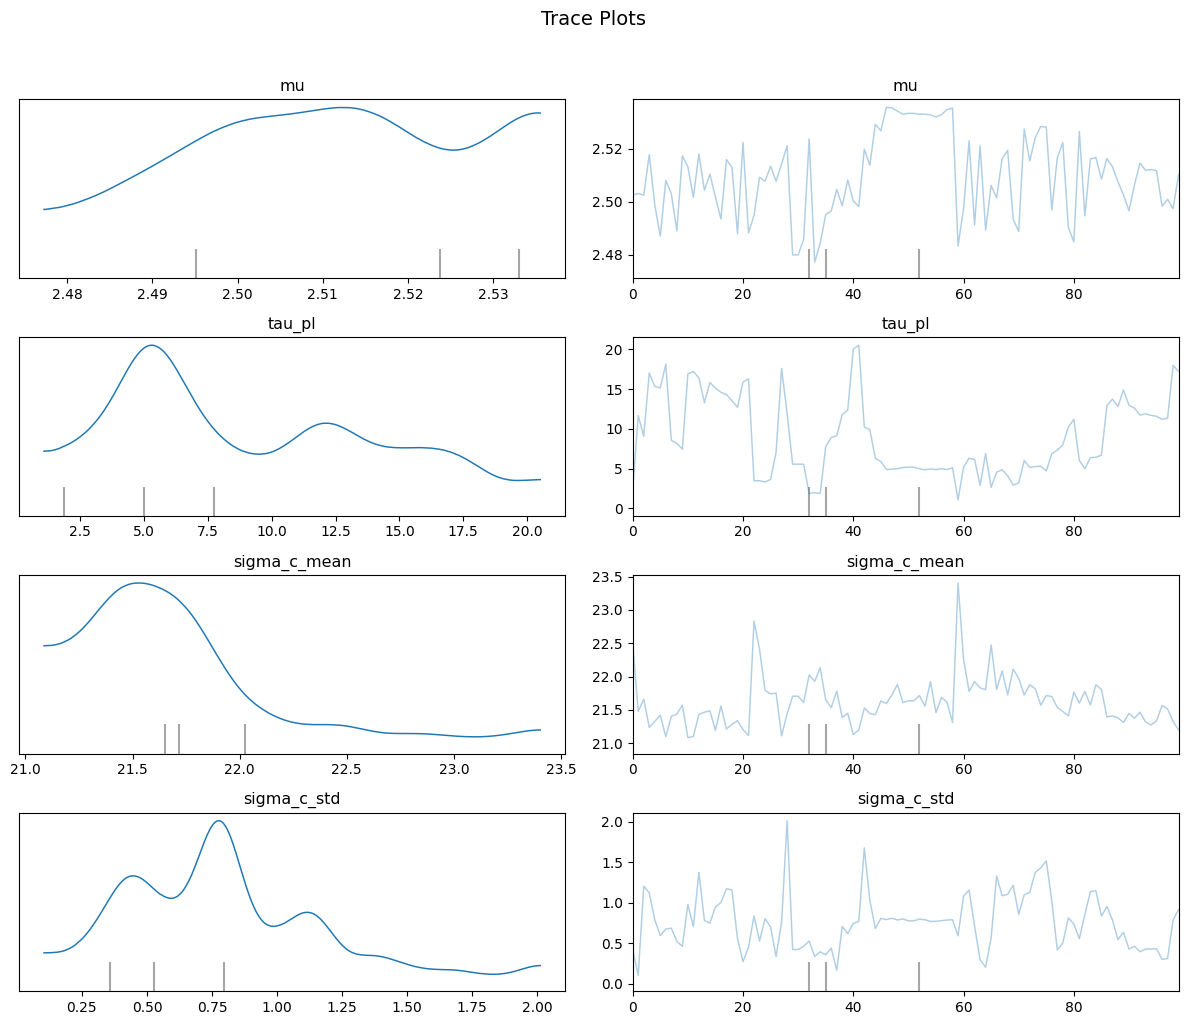

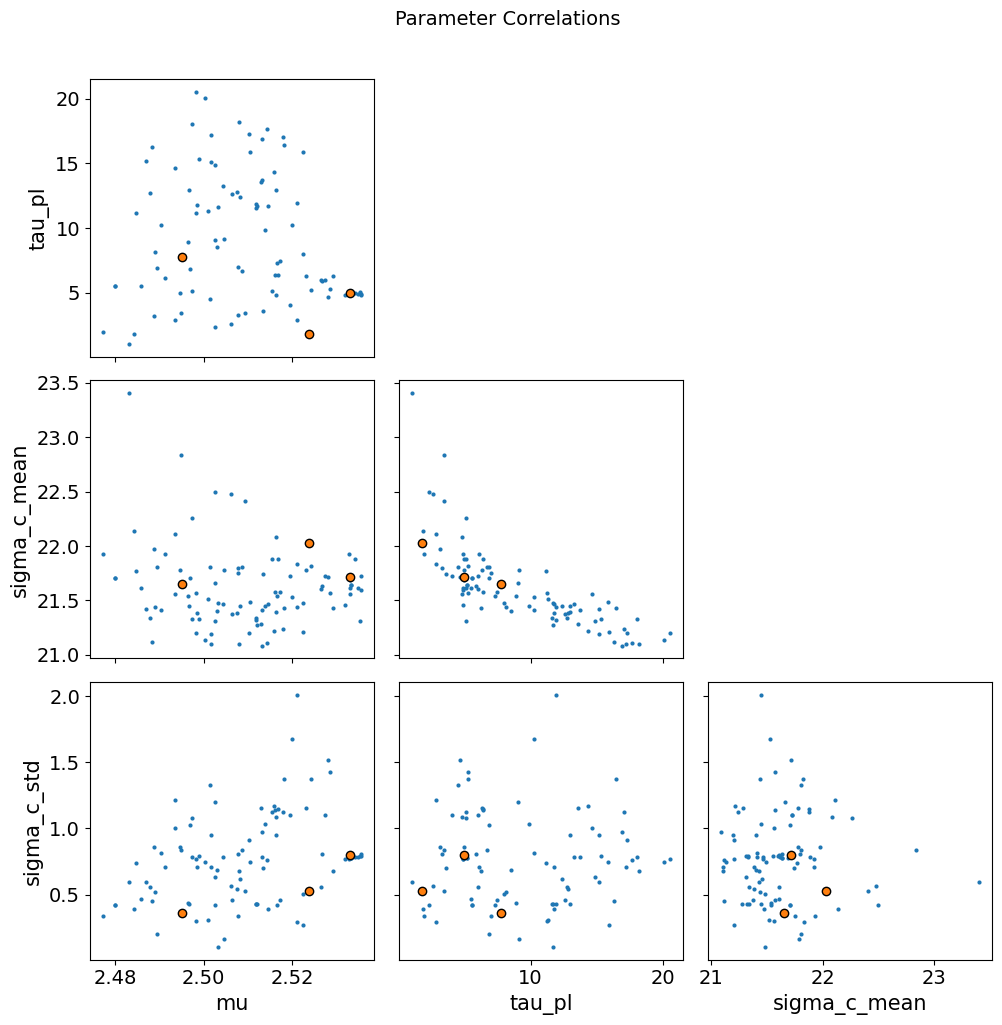

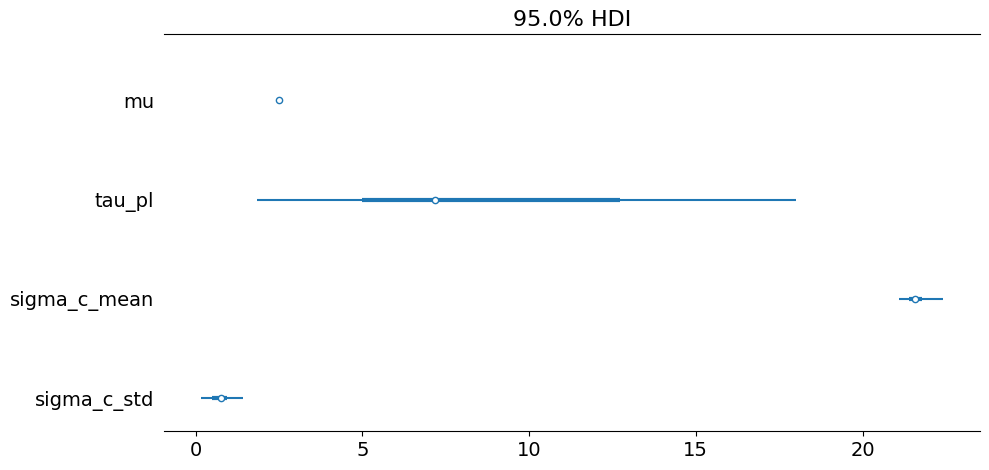

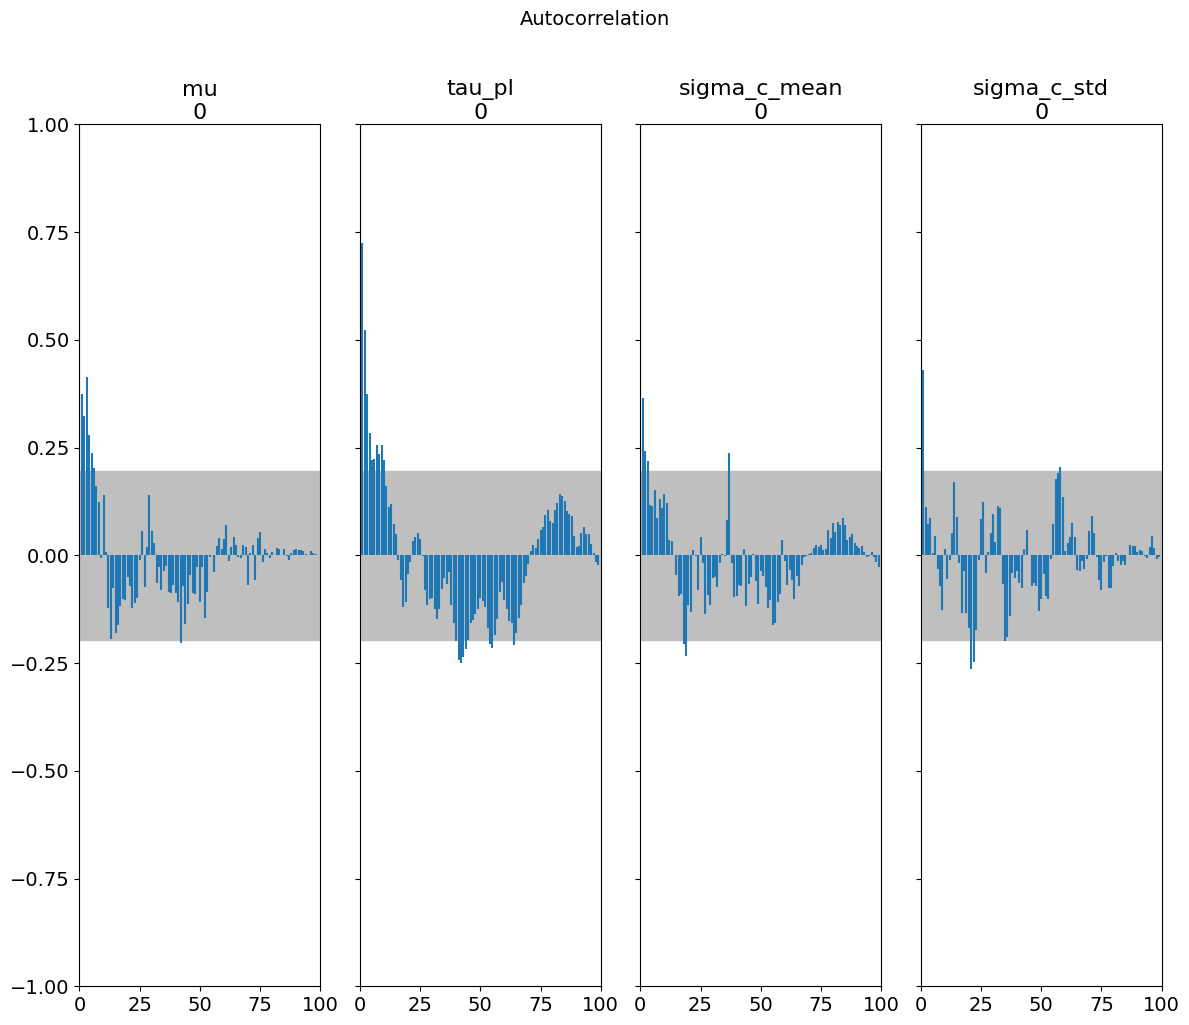

In [13]:
# ArviZ diagnostic plots
display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)

In [14]:
# Parameter recovery check with posteriors
posterior = result.posterior_samples

print("\nParameter Recovery with Bayesian Inference")
print("=" * 70)
print(f"{'Parameter':>15s}  {'True':>10s}  {'Median':>10s}  {'95% CI':>24s}  {'Recovered?':>12s}")
print("-" * 70)

for name in param_names:
    true_val = true_params.get(name, 1.0)
    samples = posterior[name]
    median = float(np.median(samples))
    lo = float(np.percentile(samples, 2.5))
    hi = float(np.percentile(samples, 97.5))
    
    # Check if true value is within 95% CI
    recovered = "✓" if lo <= true_val <= hi else "✗"
    
    print(f"{name:>15s}  {true_val:10.4g}  {median:10.4g}  [{lo:.4g}, {hi:.4g}]  {recovered:>12s}")


Parameter Recovery with Bayesian Inference
      Parameter        True      Median                    95% CI    Recovered?
----------------------------------------------------------------------
             mu         2.5        2.51  [2.482, 2.535]             ✓
         tau_pl           1       7.186  [1.915, 18.09]             ✗
   sigma_c_mean          25       21.57  [21.11, 22.49]             ✗
    sigma_c_std         2.5        0.77  [0.2354, 1.476]             ✗


## 8. TensorialEPM: N₁(t) Evolution

Using TensorialEPM, we can predict how the first normal stress difference N₁ evolves during startup.

In [15]:
# Get median parameters
median_params = {name: float(np.median(posterior[name])) for name in param_names}

# Create TensorialEPM
model_tensor = TensorialEPM(
    L=16 if FAST_MODE else 32,
    dt=0.01,
    mu=median_params["mu"],
    nu=0.48,
    tau_pl=median_params["tau_pl"],
    sigma_c_mean=median_params["sigma_c_mean"],
    sigma_c_std=median_params["sigma_c_std"],
)

# Predict startup with N₁
print("Running TensorialEPM startup simulation...")
result_tensor = model_tensor.predict(rheo_fine, smooth=True, seed=SEED)

sigma_xy_t = np.array(result_tensor.y)
N1_t = np.array(result_tensor.metadata.get("N1", np.zeros_like(sigma_xy_t)))

print(f"σ_xy range: {sigma_xy_t.min():.2f} – {sigma_xy_t.max():.2f} Pa")
print(f"N₁ range: {N1_t.min():.2f} – {N1_t.max():.2f} Pa")

Running TensorialEPM startup simulation...


σ_xy range: 0.00 – 12.51 Pa
N₁ range: 0.00 – 0.00 Pa


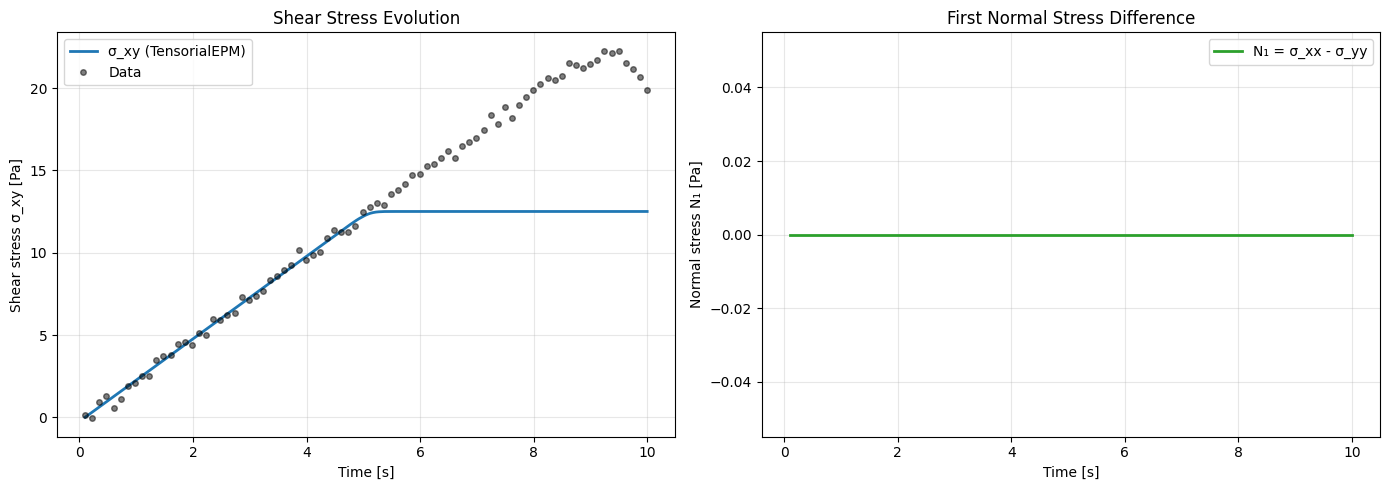

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Shear stress
ax1.plot(time_fine, sigma_xy_t, "-", lw=2, color="C0", label="σ_xy (TensorialEPM)")
ax1.plot(time_data, stress_noisy, "ko", markersize=4, alpha=0.5, label="Data")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Shear stress σ_xy [Pa]")
ax1.set_title("Shear Stress Evolution")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: Normal stress
ax2.plot(time_fine, N1_t, "-", lw=2, color="C2", label="N₁ = σ_xx - σ_yy")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Normal stress N₁ [Pa]")
ax2.set_title("First Normal Stress Difference")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

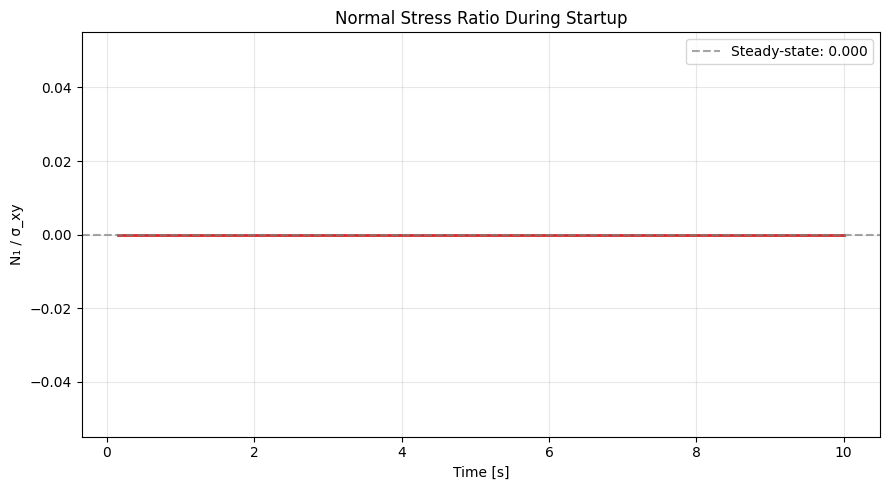

In [17]:
# N₁/σ_xy ratio over time
# Avoid division by zero
mask = sigma_xy_t > 1e-6
N1_ratio = np.zeros_like(sigma_xy_t)
N1_ratio[mask] = N1_t[mask] / sigma_xy_t[mask]

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(time_fine[mask], N1_ratio[mask], "-", lw=2, color="C3")
ax.set_xlabel("Time [s]")
ax.set_ylabel("N₁ / σ_xy")
ax.set_title("Normal Stress Ratio During Startup")
ax.grid(True, alpha=0.3)

# Steady-state ratio
ss_ratio = np.mean(N1_ratio[-20:])
ax.axhline(ss_ratio, color="gray", linestyle="--", alpha=0.7, 
           label=f"Steady-state: {ss_ratio:.3f}")
ax.legend()

plt.tight_layout()
display(fig)
plt.close(fig)

## 9. Key Takeaways

1. **Stress overshoot in EPM** arises from avalanche onset — the transition from elastic loading to cascading plasticity
2. **$\gamma_{\text{peak}}$** (peak strain) is approximately the yield strain of the material, controlled by disorder
3. **Parameter recovery** from startup data is reliable when overshoot is well-resolved (R² > 0.95)
4. **$N_1$ evolution** shows normal stress buildup during shear startup (TensorialEPM)
5. The **$N_1/\sigma_{xy}$ ratio** approaches a steady value that characterizes the material's nonlinearity

## Next Steps

- **Notebook 04**: Creep response and yield stress estimation
- **Notebook 05**: Stress relaxation and relaxation spectrum
- **Notebook 06**: Visualization of avalanche dynamics (spatial stress fields)

## Further Reading

**Handbook:**
- [Lattice EPM — Startup Protocol](../../docs/source/models/epm/lattice_epm.rst#epm-startup) — Boxed governing equations for startup flow

**Key References:**
- Picard, G., Ajdari, A., Lequeux, F., & Bocquet, L. (2004). "Elastic consequences of a single plastic event." *European Physical Journal E*, 15, 371-381.
- Lin, J., Lerner, E., Rosso, A., & Wyart, M. (2014). "Scaling description of the yielding transition in soft amorphous solids at zero temperature." *PNAS*, 111, 14382-14387.

In [18]:
# Save results
output_dir = os.path.join("..", "outputs", "epm", "startup")
os.makedirs(output_dir, exist_ok=True)

with open(os.path.join(output_dir, "nlsq_params_startup.json"), "w") as f:
    json.dump(median_params, f, indent=2)

print(f"Results saved to {output_dir}/")

Results saved to ../outputs/epm/startup/
